In [1]:
import os
import numpy as np
import pandas as pd

import rasterio

from pathlib import Path
from pandas_path import path

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [217]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Load data

In [2]:
PATH_TO_DATA = './data/'
os.listdir(PATH_TO_DATA)

['flood-training-metadata.csv', 'train_features', 'train_labels']

In [3]:
train_metadata = pd.read_csv(
    os.path.join(PATH_TO_DATA, 'flood-training-metadata.csv'),
    parse_dates=["scene_start"]
)
train_metadata.shape

(1084, 6)

In [4]:
train_metadata.head()

image_id chip_id flood_id polarization location scene_start
0  awc00_vh   awc00      awc           vh  Bolivia  2018-02-15
1  awc00_vv   awc00      awc           vv  Bolivia  2018-02-15
2  awc01_vh   awc01      awc           vh  Bolivia  2018-02-15
3  awc01_vv   awc01      awc           vv  Bolivia  2018-02-15
4  awc02_vh   awc02      awc           vh  Bolivia  2018-02-15

In [10]:
DATA_PATH = Path("./data/")

In [11]:
DATA_PATH / "train_features"

PosixPath('data/train_features')

In [12]:
train_metadata["feature_path"] = (
    str(DATA_PATH / "train_features")
    / train_metadata.image_id.path.with_suffix(".tif").path
)

In [13]:
train_metadata["label_path"] = (
    str(DATA_PATH / "train_labels")
    / train_metadata.chip_id.path.with_suffix(".tif").path
)

In [14]:
train_metadata.head()

image_id chip_id flood_id polarization location scene_start  \
0  awc00_vh   awc00      awc           vh  Bolivia  2018-02-15   
1  awc00_vv   awc00      awc           vv  Bolivia  2018-02-15   
2  awc01_vh   awc01      awc           vh  Bolivia  2018-02-15   
3  awc01_vv   awc01      awc           vv  Bolivia  2018-02-15   
4  awc02_vh   awc02      awc           vh  Bolivia  2018-02-15   

                       feature_path                   label_path  
0  data/train_features/awc00_vh.tif  data/train_labels/awc00.tif  
1  data/train_features/awc00_vv.tif  data/train_labels/awc00.tif  
2  data/train_features/awc01_vh.tif  data/train_labels/awc01.tif  
3  data/train_features/awc01_vv.tif  data/train_labels/awc01.tif  
4  data/train_features/awc02_vh.tif  data/train_labels/awc02.tif

In [279]:
train_metadata.groupby('flood_id')['location'].describe()

count unique        top freq
flood_id                             
awc         30      1    Bolivia   30
ayt         36      1    Nigeria   36
coz         56      1   Pakistan   56
hbe        138      1        USA  138
hxu         52      1    Somalia   52
jja        132      1   Paraguay  132
kuo        130      1   Slovakia  130
pxs        136      1      India  136
qus         60      1   Cambodia   60
qxb         84      1  Sri Lanka   84
tht         60      1      Spain   60
tnp        106      1      Ghana  106
wvy         64      1         UK   64

In [25]:
def get_data_by_chip(image_level_df):
    paths = []
    for chip, group in image_level_df.groupby("chip_id"):
        vv_path = group[group.polarization == "vv"]["feature_path"].values[0]
        vh_path = group[group.polarization == "vh"]["feature_path"].values[0]
        label_path = group["label_path"].values[0]
        flood_id = group["flood_id"].values[0]
        location = group["location"].values[0]
        paths.append([chip, vv_path, vh_path, label_path, flood_id, location])
    return pd.DataFrame(paths, columns=["chip_id", "vv_path", "vh_path", "label_path", "flood_id", "location"])

In [26]:
train_path = get_data_by_chip(train_metadata)

print(len(train_path))
train_path.head()

542


chip_id                           vv_path                           vh_path  \
0   awc00  data/train_features/awc00_vv.tif  data/train_features/awc00_vh.tif   
1   awc01  data/train_features/awc01_vv.tif  data/train_features/awc01_vh.tif   
2   awc02  data/train_features/awc02_vv.tif  data/train_features/awc02_vh.tif   
3   awc03  data/train_features/awc03_vv.tif  data/train_features/awc03_vh.tif   
4   awc04  data/train_features/awc04_vv.tif  data/train_features/awc04_vh.tif   

                    label_path flood_id  
0  data/train_labels/awc00.tif      awc  
1  data/train_labels/awc01.tif      awc  
2  data/train_labels/awc02.tif      awc  
3  data/train_labels/awc03.tif      awc  
4  data/train_labels/awc04.tif      awc

<AxesSubplot:>

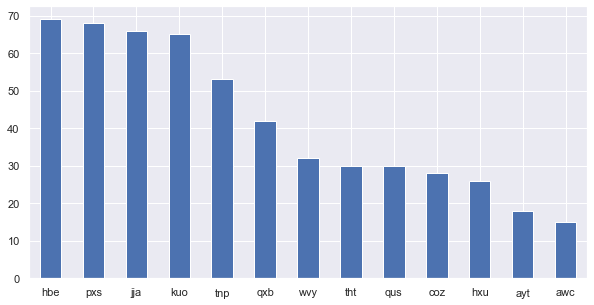

In [221]:
plt.figure(figsize=(10,5))

value_counts = train_path['flood_id'].value_counts()
value_counts.plot(kind='bar', rot=0)

In [222]:
value_counts

hbe    69
pxs    68
jja    66
kuo    65
tnp    53
qxb    42
wvy    32
tht    30
qus    30
coz    28
hxu    26
ayt    18
awc    15
Name: flood_id, dtype: int64

# Water / Ground / Mask

In [83]:
value_to_column = {
    0:'ground',
    1:'water',
    255:'mask'
}

In [84]:
for i, row in train_path.iterrows():
    label_path = row['label_path']
    with rasterio.open(label_path) as lp:
        lp_img = lp.read(1)
        
    values, counts = np.unique(lp_img, return_counts=True)
    for i_v, v in enumerate(values):
        column = value_to_column[v]
        count = counts[i_v]
        train_path.loc[i, column] = count

In [88]:
train_path = train_path.fillna(0)

In [89]:
train_path.head()

chip_id                           vv_path                           vh_path  \
0   awc00  data/train_features/awc00_vv.tif  data/train_features/awc00_vh.tif   
1   awc01  data/train_features/awc01_vv.tif  data/train_features/awc01_vh.tif   
2   awc02  data/train_features/awc02_vv.tif  data/train_features/awc02_vh.tif   
3   awc03  data/train_features/awc03_vv.tif  data/train_features/awc03_vh.tif   
4   awc04  data/train_features/awc04_vv.tif  data/train_features/awc04_vh.tif   

                    label_path flood_id    ground      mask     water  
0  data/train_labels/awc00.tif      awc  192027.0   70117.0       0.0  
1  data/train_labels/awc01.tif      awc  262144.0       0.0       0.0  
2  data/train_labels/awc02.tif      awc  237981.0   17411.0    6752.0  
3  data/train_labels/awc03.tif      awc   37598.0  109815.0  114731.0  
4  data/train_labels/awc04.tif      awc  126419.0       0.0  135725.0

In [92]:
train_path.flood_id.unique()

array(['awc', 'ayt', 'coz', 'hbe', 'hxu', 'jja', 'kuo', 'pxs', 'qus',
       'qxb', 'tht', 'tnp', 'wvy'], dtype=object)

## Examples with no label

In [127]:
empty_label = train_path[train_path['water'] == 0]
empty_label.shape

(60, 8)

<AxesSubplot:title={'center':'Empty labels by flood'}>

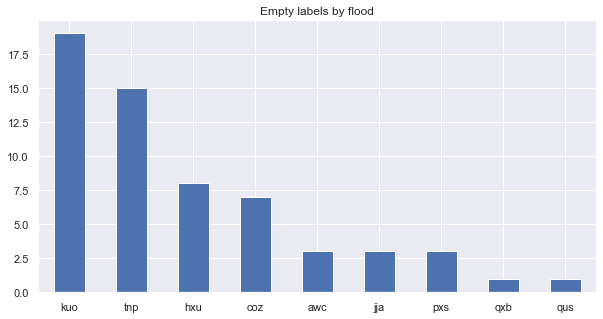

In [128]:
plt.figure(figsize=(10,5))
plt.title('Empty labels by flood')
value_counts = empty_label['flood_id'].value_counts()
value_counts.plot(kind='bar', rot=0)

## Floods

In [104]:
train_path[(train_path.flood_id == 'qus') & (train_path['mask'] > 0)]#['mask'].hist(bins=30)

chip_id                           vv_path  \
359   qus04  data/train_features/qus04_vv.tif   
366   qus11  data/train_features/qus11_vv.tif   
370   qus15  data/train_features/qus15_vv.tif   

                              vh_path                   label_path flood_id  \
359  data/train_features/qus04_vh.tif  data/train_labels/qus04.tif      qus   
366  data/train_features/qus11_vh.tif  data/train_labels/qus11.tif      qus   
370  data/train_features/qus15_vh.tif  data/train_labels/qus15.tif      qus   

       ground     mask     water  
359  187061.0  73995.0    1088.0  
366  205008.0  24440.0   32696.0  
370   58064.0      1.0  204079.0

In [98]:
train_path.groupby("flood_id")["water"].describe()

count           mean           std     min        25%       50%  \
flood_id                                                                    
awc        15.0   48408.133333  54756.430680     0.0    7671.50   19732.0   
ayt        18.0   54609.722222  70903.525447    77.0     985.50   11270.0   
coz        28.0   21076.892857  31932.954622     0.0      83.25    5971.0   
hbe        69.0   11909.304348  17598.741604   165.0    1973.00    3655.0   
hxu        26.0   13462.076923  16708.214844     0.0       0.00    5830.5   
jja        66.0   31666.151515  43241.509052     0.0     937.00   10388.0   
kuo        65.0    4734.538462  11946.520145     0.0       0.00     724.0   
pxs        68.0   37329.676471  41355.547246     0.0    5418.75   20827.0   
qus        30.0   66659.800000  71809.976787     0.0    8441.75   29043.5   
qxb        42.0   32469.476190  55861.205032     0.0    2862.50   15322.0   
tht        30.0   35992.266667  49961.879485   237.0    3220.75   13767.0   
tnp        53.0   16395.830189  41092.393434     0.0       0.00     605.0   
wvy        32.0  207457.750000  72825.736739  4552.0  165124.50  253975.0   

                75%       max  
flood_id                       
awc        84179.00  142699.0  
ayt       108564.50  218535.0  
coz        22956.00  104094.0  
hbe        17174.00   85116.0  
hxu        27596.75   58944.0  
jja        48694.00  168704.0  
kuo         2582.00   81189.0  
pxs        51649.50  169965.0  
qus       113756.25  204079.0  
qxb        41745.75  257242.0  
tht        61339.50  212335.0  
tnp         6030.00  199356.0  
wvy       262144.00  262144.0

In [99]:
train_path.groupby("flood_id")["mask"].describe()

count          mean           std  min  25%  50%      75%       max
flood_id                                                                     
awc        15.0  22021.200000  36827.058587  0.0  0.0  0.0  37748.0  109815.0
ayt        18.0   9760.888889  27257.704771  0.0  0.0  0.0      0.0  106028.0
coz        28.0   5220.071429  27622.021652  0.0  0.0  0.0      0.0  146162.0
hbe        69.0   2094.666667  10329.375593  0.0  0.0  0.0      0.0   62821.0
hxu        26.0   6814.730769  24416.742242  0.0  0.0  0.0      0.0  102996.0
jja        66.0   3699.848485  17178.142614  0.0  0.0  0.0      0.0  104308.0
kuo        65.0      0.000000      0.000000  0.0  0.0  0.0      0.0       0.0
pxs        68.0   8404.617647  30528.789968  0.0  0.0  0.0      0.0  144877.0
qus        30.0   3281.200000  14080.538566  0.0  0.0  0.0      0.0   73995.0
qxb        42.0      0.000000      0.000000  0.0  0.0  0.0      0.0       0.0
tht        30.0      0.000000      0.000000  0.0  0.0  0.0      0.0       0.0
tnp        53.0   4409.962264  20976.118002  0.0  0.0  0.0      0.0  116585.0
wvy        32.0  17227.281250  57612.779585  0.0  0.0  0.0      0.0  257592.0

<AxesSubplot:title={'center':'Small labels by flood'}>

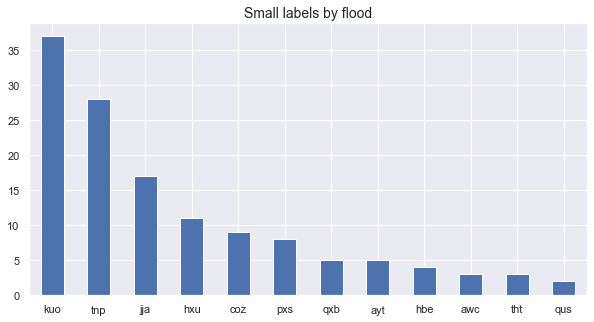

In [405]:
plt.figure(figsize=(10,5))
plt.title('Small labels by flood', fontsize=14)
value_counts = train_path[train_path['water'] < 1000]['flood_id'].value_counts()
value_counts.plot(kind='bar', rot=0)

In [ ]:
# val_flood_ids = ['kuo', 'tht', 'qus'] VALID V1
# val_flood_ids = ['qus', 'hxu', 'pxs'] VALID V2

<AxesSubplot:title={'center':'Mask images by flood'}>

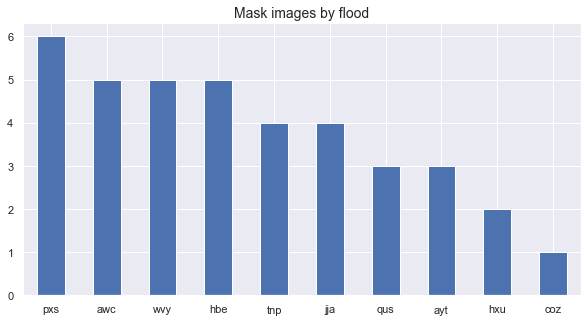

In [404]:
plt.figure(figsize=(10,5))
plt.title('Mask images by flood', fontsize=14)
value_counts = train_path[train_path['mask'] > 0]['flood_id'].value_counts()
value_counts.plot(kind='bar', rot=0)

In [125]:
mask_by_flood_id = train_path.groupby("flood_id")["mask"].sum().sort_values(ascending=False)
# mask_by_flood_id

[]

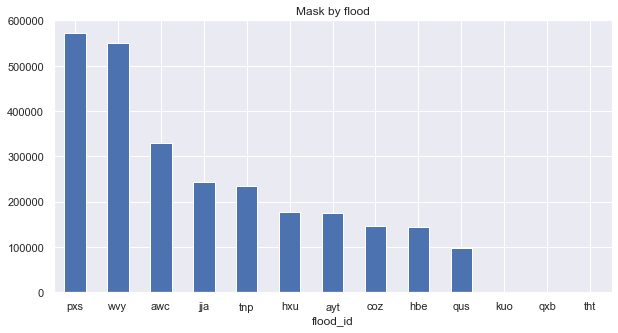

In [121]:
plt.figure(figsize=(10,5))
plt.title('Mask by flood')
mask_by_flood_id.plot(kind='bar', rot=0)
plt.plot()

In [122]:
water_by_flood_id = train_path.groupby("flood_id")["water"].sum().sort_values(ascending=False)
# water_by_flood_id

[]

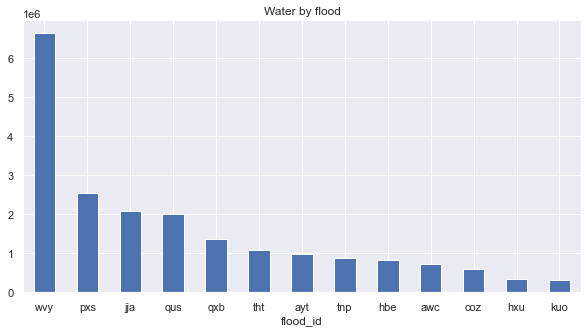

In [123]:
plt.figure(figsize=(10,5))
plt.title('Water by flood')
water_by_flood_id.plot(kind='bar', rot=0)
plt.plot()

In [120]:
ground_by_flood_id = train_path.groupby("flood_id")["ground"].sum().sort_values(ascending=False)
# ground_by_flood_id

[]

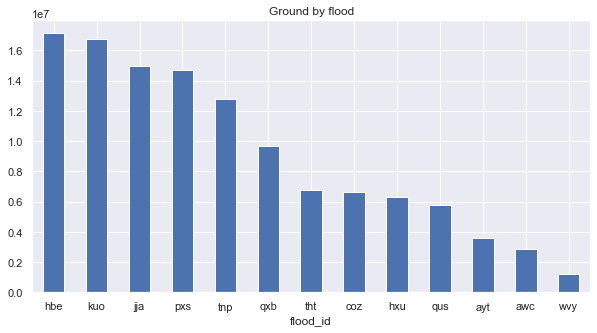

In [124]:
plt.figure(figsize=(10,5))
plt.title('Ground by flood')
ground_by_flood_id.plot(kind='bar', rot=0)
plt.plot()

In [147]:
train_path["ground"].sum() / train_path["water"].sum()

5.847859730321806

In [149]:
train_path["ground"].sum() / train_path["mask"].sum()

44.53780351301443

In [150]:
train_path["water"].sum() / train_path["mask"].sum()

7.61608615235433

<AxesSubplot:>

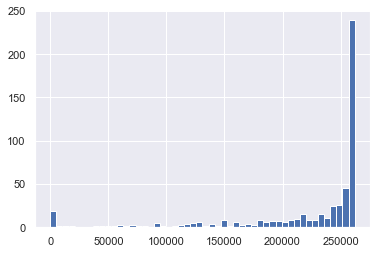

In [146]:
train_path["ground"].hist(bins=50)

<AxesSubplot:>

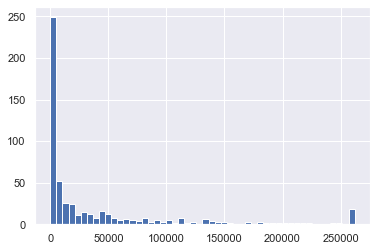

In [131]:
train_path["water"].hist(bins=50)

# Min/max dataset values

In [436]:
min_values_vv = []
max_values_vv = []
mean_values_vv = []

min_values_vh = []
max_values_vh = []
mean_values_vh = []

for i, row in train_path.iterrows():
    vv_path = row['vv_path']
    vh_path = row['vh_path']
    
    with rasterio.open(vv_path) as vv:
        vv_path = vv.read(1)
    with rasterio.open(vh_path) as vh:
        vh_path = vh.read(1)
        
#     x_arr = np.stack([vv_path, vh_path], axis=-1)
    
#     min_values.append(x_arr.min())
#     max_values.append(x_arr.max())
#     mean_values.append(x_arr.mean())
    
    min_values_vv.append(vv_path.min())
    max_values_vv.append(vv_path.max())
    mean_values_vv.append(vv_path.mean())

    min_values_vh.append(vh_path.min())
    max_values_vh.append(vh_path.max())
    mean_values_vh.append(vh_path.mean())

In [437]:
# min_values = np.array(min_values)
# max_values = np.array(max_values)
# mean_values = np.array(mean_values)

min_values_vv = np.array(min_values_vv)
max_values_vv = np.array(max_values_vv)
mean_values_vv = np.array(mean_values_vv)

min_values_vh = np.array(min_values_vh)
max_values_vh = np.array(max_values_vh)
mean_values_vh = np.array(mean_values_vh)

## min / max

In [161]:
min_values.min(), min_values.mean(), min_values.max()

(-79.141174, -40.403164, -25.843702)

In [162]:
max_values.min(), max_values.mean(), max_values.max()

(-17.817469, 8.150381, 34.4235)

In [163]:
mean_values.min(), mean_values.mean(), mean_values.max()

(-29.023949, -14.161605, -0.46291777)

## min / max vv

In [438]:
min_values_vv.min(), min_values_vv.mean(), min_values_vv.max()

(-70.6078, -30.722174, -18.12655)

In [440]:
max_values_vv.min(), max_values_vv.mean(), max_values_vv.max()

(-17.817469, 8.141321, 34.4235)

## min / max vh

In [439]:
min_values_vh.min(), min_values_vh.mean(), min_values_vh.max()

(-79.141174, -40.398552, -25.843702)

In [441]:
max_values_vh.min(), max_values_vh.mean(), max_values_vh.max()

(-24.811129, -0.8573382, 27.942997)

# Look at images

In [197]:
import warnings

warnings.filterwarnings("ignore")

In [245]:
from plot_utils import show_chip_by_id, show_chip_by_index, show_chip_by_iloc

In [195]:
train_path.flood_id.unique()

array(['awc', 'ayt', 'coz', 'hbe', 'hxu', 'jja', 'kuo', 'pxs', 'qus',
       'qxb', 'tht', 'tnp', 'wvy'], dtype=object)

In [196]:
# train_path[train_path.flood_id=='pxs']

In [192]:
# train_path

Flood: awc
Chip: awc07
Label: 142699


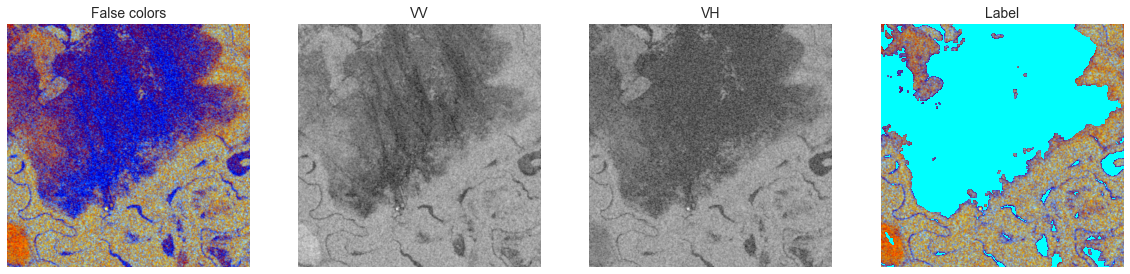

In [237]:
show_chip_by_index(7, train_path)

In [200]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display as display_widget

In [445]:
dataset_to_show = train_path

# A lot of masks
# dataset_to_show = train_path[train_path.flood_id=='pxs']

# A lot of masks and water
# dataset_to_show = train_path[train_path.flood_id=='wvy']

# A lot of ground, small water and no mask
# dataset_to_show = train_path[train_path.flood_id=='kuo']

# A little of everything
# dataset_to_show = train_path[train_path.flood_id=='qus']


# dataset_to_show = train_path[train_path["water"]==262144]
print(len(dataset_to_show))

542


In [446]:
w = widgets.BoundedIntText(
    value=0,
    min=0,
    max=len(dataset_to_show)-1,
    step=1,
    description='Index:',
    disabled=False
)

def handle_change(x):
    show_chip_by_iloc(x, dataset_to_show)

In [447]:
interact(handle_change, x=w)

interactive(children=(BoundedIntText(value=0, description='Index:', max=541), Output()), _dom_classes=('widget…

<function __main__.handle_change(x)>

## Similar images

Flood: pxs
Chip: pxs59
Label: 122292


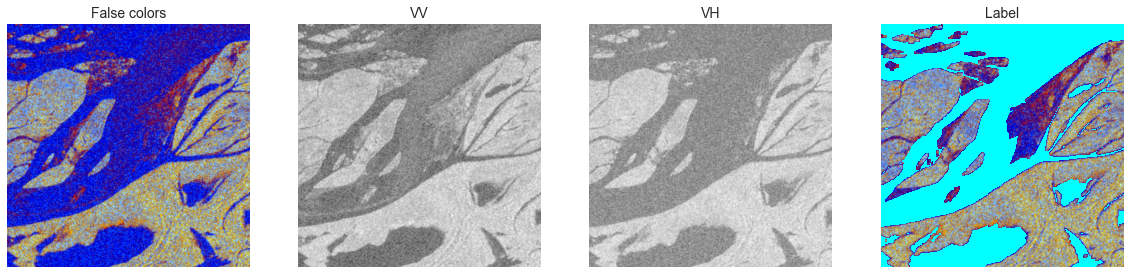

In [280]:
show_chip_by_id('pxs59', train_path)

## Bad labeling?
TODO: test your model on these images

Flood: awc
Chip: awc08
Label: 14203


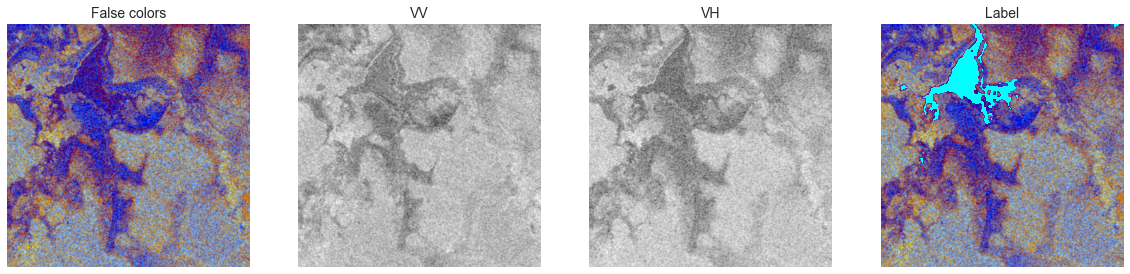

In [397]:
show_chip_by_id('awc08', train_path)

Flood: qus
Chip: qus01
Label: 20712


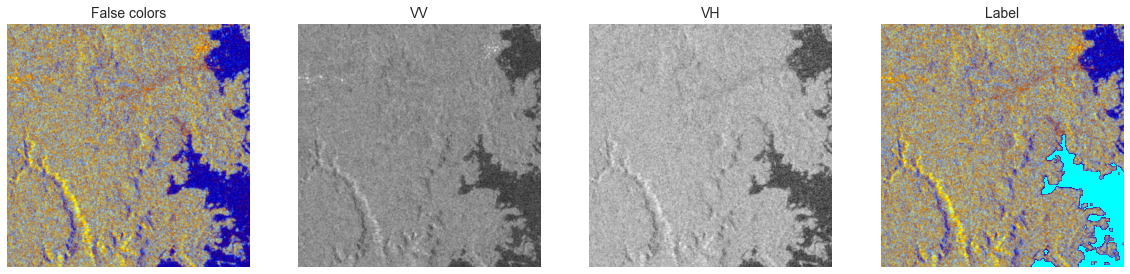

In [297]:
show_chip_by_id('qus01', train_path)

Flood: kuo
Chip: kuo14
Label: 14463


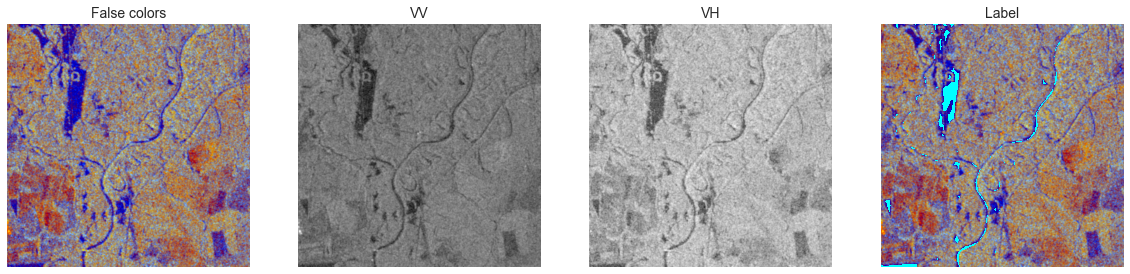

In [291]:
show_chip_by_id('kuo14', train_path)

## Interesting images

Flood: kuo
Chip: kuo27
Label: 0


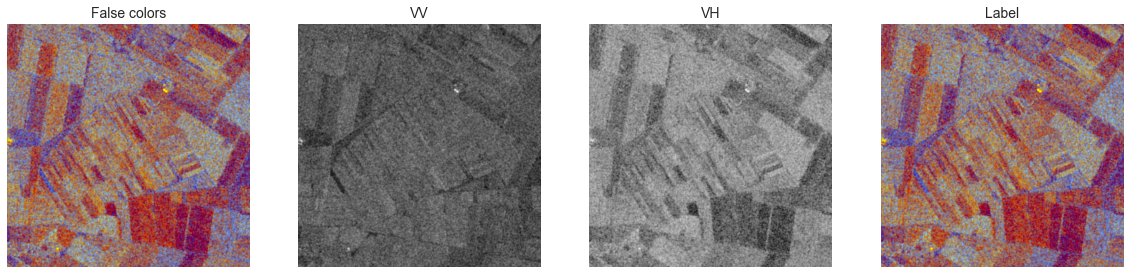

In [292]:
# поля
show_chip_by_id('kuo27', train_path)

Flood: kuo
Chip: kuo01
Label: 5203


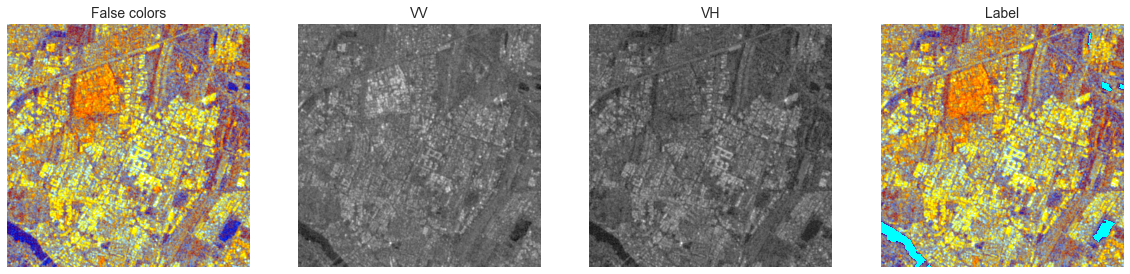

In [290]:
# город или поселок или просто поля
show_chip_by_id('kuo01', train_path)

Flood: wvy
Chip: wvy26
Label: 205777


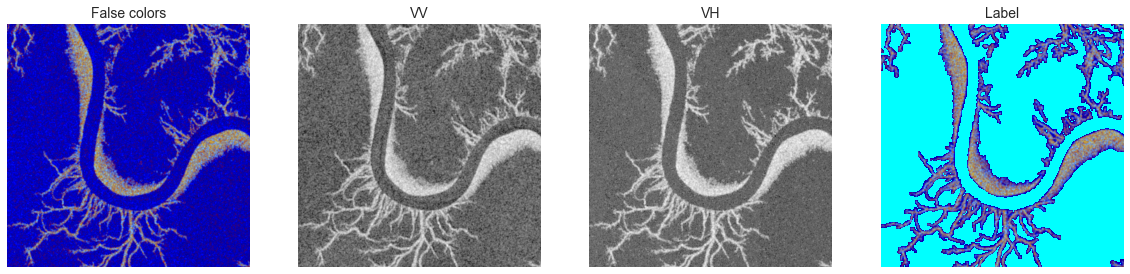

In [285]:
# река вышла из берегов
show_chip_by_id('wvy26', train_path)

## Small label images

Flood: kuo
Chip: kuo61
Label: 1643


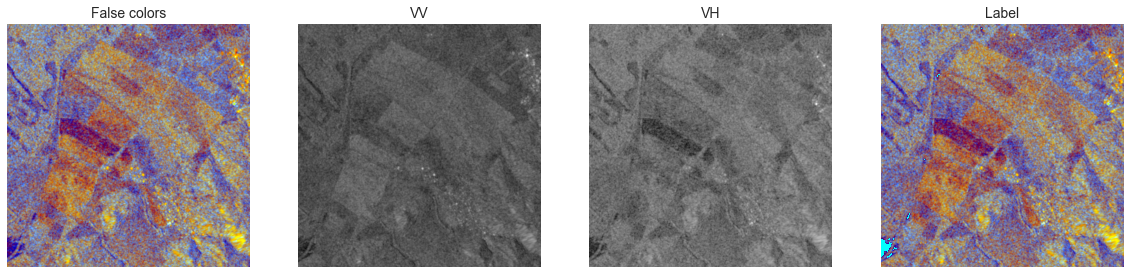

In [293]:
show_chip_by_id('kuo61', train_path)

Flood: kuo
Chip: kuo05
Label: 1075


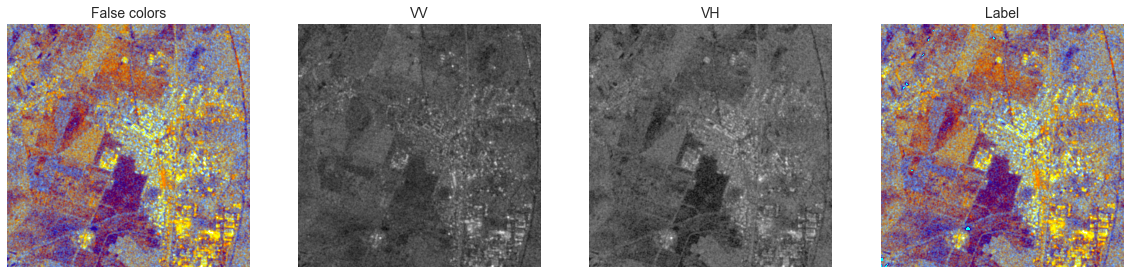

In [289]:
show_chip_by_id('kuo05', train_path)

Flood: pxs
Chip: pxs60
Label: 262


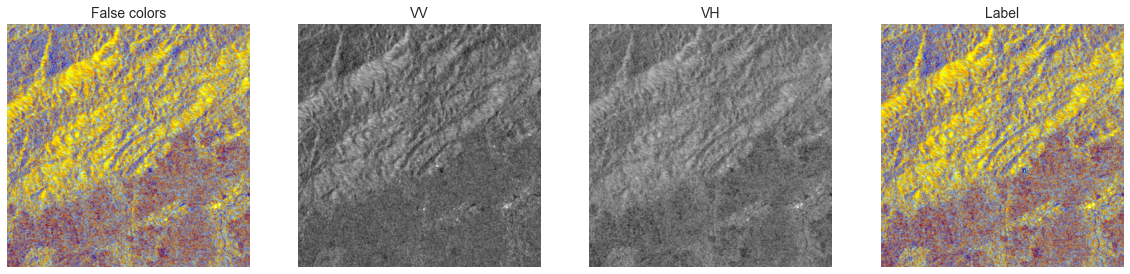

In [281]:
show_chip_by_id('pxs60', train_path)

Flood: pxs
Chip: pxs36
Label: 906


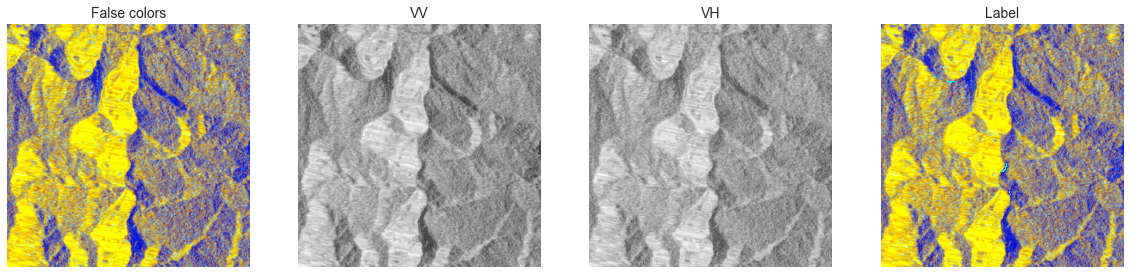

In [276]:
show_chip_by_id('pxs36', train_path)

Flood: ayt
Chip: ayt04
Label: 575


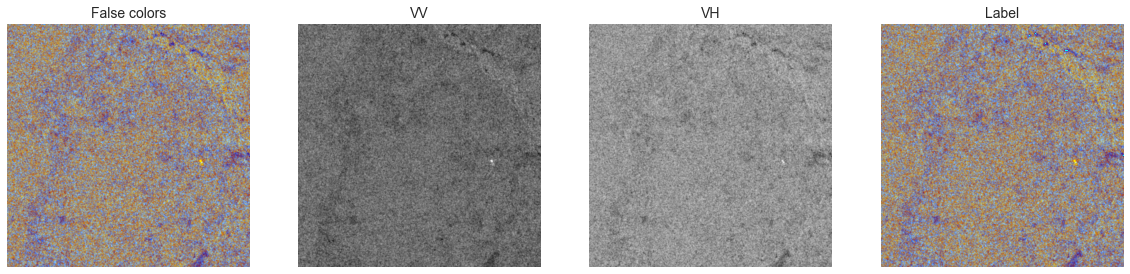

In [241]:
show_chip_by_id('ayt04', train_path)

## Max water images

In [242]:
train_path["water"].sort_values(ascending=False)

524    262144.0
517    262144.0
533    262144.0
532    262144.0
530    262144.0
         ...   
467         0.0
235         0.0
239         0.0
243         0.0
0           0.0
Name: water, Length: 542, dtype: float64

In [243]:
train_path[train_path["water"]==262144]

chip_id                           vv_path  \
512   wvy02  data/train_features/wvy02_vv.tif   
513   wvy03  data/train_features/wvy03_vv.tif   
517   wvy07  data/train_features/wvy07_vv.tif   
521   wvy11  data/train_features/wvy11_vv.tif   
524   wvy14  data/train_features/wvy14_vv.tif   
525   wvy15  data/train_features/wvy15_vv.tif   
530   wvy20  data/train_features/wvy20_vv.tif   
532   wvy22  data/train_features/wvy22_vv.tif   
533   wvy23  data/train_features/wvy23_vv.tif   
538   wvy28  data/train_features/wvy28_vv.tif   
540   wvy30  data/train_features/wvy30_vv.tif   

                              vh_path                   label_path flood_id  \
512  data/train_features/wvy02_vh.tif  data/train_labels/wvy02.tif      wvy   
513  data/train_features/wvy03_vh.tif  data/train_labels/wvy03.tif      wvy   
517  data/train_features/wvy07_vh.tif  data/train_labels/wvy07.tif      wvy   
521  data/train_features/wvy11_vh.tif  data/train_labels/wvy11.tif      wvy   
524  data/train_features/wvy14_vh.tif  data/train_labels/wvy14.tif      wvy   
525  data/train_features/wvy15_vh.tif  data/train_labels/wvy15.tif      wvy   
530  data/train_features/wvy20_vh.tif  data/train_labels/wvy20.tif      wvy   
532  data/train_features/wvy22_vh.tif  data/train_labels/wvy22.tif      wvy   
533  data/train_features/wvy23_vh.tif  data/train_labels/wvy23.tif      wvy   
538  data/train_features/wvy28_vh.tif  data/train_labels/wvy28.tif      wvy   
540  data/train_features/wvy30_vh.tif  data/train_labels/wvy30.tif      wvy   

     ground  mask     water  
512     0.0   0.0  262144.0  
513     0.0   0.0  262144.0  
517     0.0   0.0  262144.0  
521     0.0   0.0  262144.0  
524     0.0   0.0  262144.0  
525     0.0   0.0  262144.0  
530     0.0   0.0  262144.0  
532     0.0   0.0  262144.0  
533     0.0   0.0  262144.0  
538     0.0   0.0  262144.0  
540     0.0   0.0  262144.0

Flood: wvy
Chip: wvy02
Label: 1


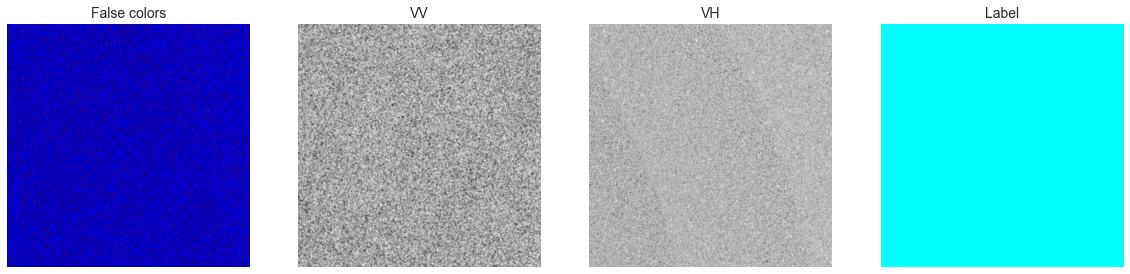

In [240]:
show_chip_by_id('wvy02', train_path)

In [168]:
def show_image_grid():
    pass

# Image values

In [391]:
from plot_utils import show_image_hist_by_iloc, show_image_hist_by_id

Flood: pxs
Chip: pxs65


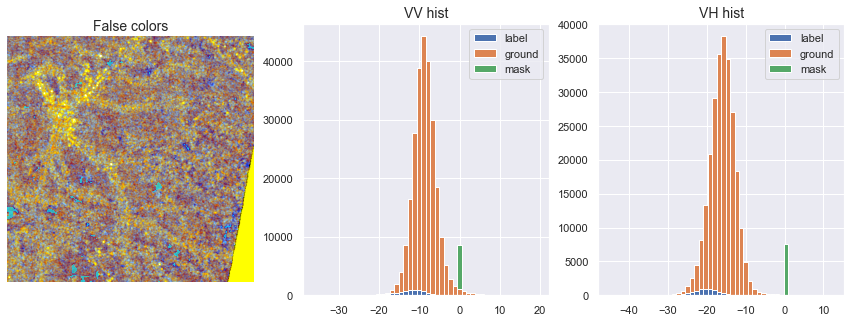

In [402]:
show_image_hist_by_id('pxs65', train_path)

In [453]:
dataset_to_show = train_path

# A lot of masks
# dataset_to_show = train_path[train_path.flood_id=='pxs']

# A lot of masks and water
# dataset_to_show = train_path[train_path.flood_id=='wvy']

# A lot of ground, small water and no mask
# dataset_to_show = train_path[train_path.flood_id=='kuo']

# A little of everything
# dataset_to_show = train_path[train_path.flood_id=='qus']

# dataset_to_show = train_path[train_path["water"]==262144]

# dataset_to_show = train_path[train_path['mask'] > 0]
print(len(dataset_to_show))

542


In [454]:
w = widgets.BoundedIntText(
    value=0,
    min=0,
    max=len(dataset_to_show)-1,
    step=1,
    description='Index:',
    disabled=False
)

def handle_change(x):
    show_image_hist_by_iloc(x, dataset_to_show)

In [455]:
interact(handle_change, x=w)

interactive(children=(BoundedIntText(value=0, description='Index:', max=541), Output()), _dom_classes=('widget…

<function __main__.handle_change(x)>

# Read single image

In [458]:
chip_id = 'awc03' # kuo01, awc03
row = train_path[train_path.chip_id == chip_id].iloc[0]

In [459]:
with rasterio.open(row.vv_path) as vv:
    vv_img = vv.read(1)
    vv_mask = vv.read(1, masked=True)
with rasterio.open(row.vh_path) as vh:
    vh_img = vh.read(1)
    vh_mask = vh.read(1, masked=True)
with rasterio.open(row.label_path) as lp:
    lp_img = lp.read(1)

In [460]:
vv_mask

masked_array(
  data=[[-13.674654960632324, -14.04920482635498, -12.48063850402832,
         ..., -20.768112182617188, -20.48207664489746,
         -20.740245819091797],
        [-16.919403076171875, -16.972557067871094, -13.636969566345215,
         ..., -21.00558853149414, -17.922178268432617,
         -18.242504119873047],
        [-17.799991607666016, -18.877532958984375, -15.624228477478027,
         ..., -23.02997589111328, -17.214183807373047,
         -17.211729049682617],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0.0,
  dtype=f

In [484]:
vv_mask.mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [465]:
vv_mask.mask.shape

(512, 512)

In [479]:
random_img = torch.rand((4, 2, 512, 512))
random_img.shape

torch.Size([4, 512, 512])

In [483]:
# plt.hist(random_img[0].reshape(-1), bins=50)
# plt.show()

In [477]:
random_img = random_img * (1 - vv_mask.mask)

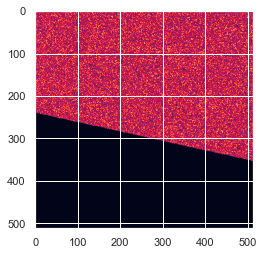

In [478]:
plt.imshow(random_img[0])

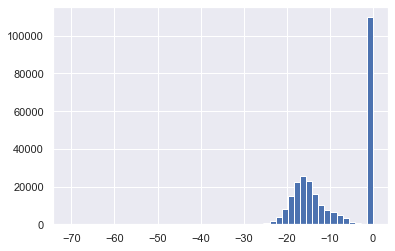

In [482]:
plt.hist(vv_img.reshape(-1), bins=50)
plt.show()

In [418]:
s1_img = np.stack((vv_img, vh_img), axis=-1)
s1_img.shape

(512, 512, 2)

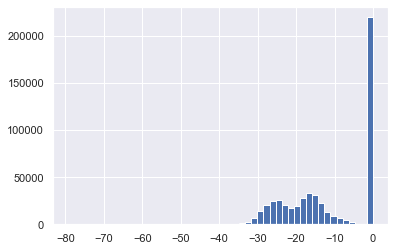

In [419]:
plt.hist(s1_img.reshape(-1), bins=50)
plt.show()

In [420]:
w, h, d = s1_img.shape
s1_img = np.reshape(s1_img, [w * h, d]).astype(np.float64)
s1_img.shape

(262144, 2)

In [421]:
# Set min/max values
min_values = np.array([-23, -28])
max_values = np.array([0, -5])

In [422]:
# Scale by min/max
s1_img = (s1_img - min_values[None, :]) / (
    max_values[None, :] - min_values[None, :]
)
s1_img = np.reshape(s1_img, [w, h, d])

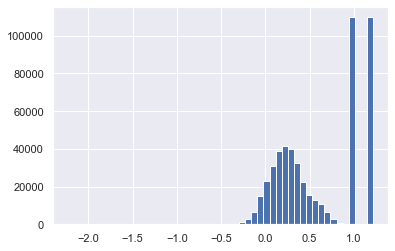

In [423]:
plt.hist(s1_img.reshape(-1), bins=50)
plt.show()

In [426]:
s1_img = s1_img.clip(0, 1)

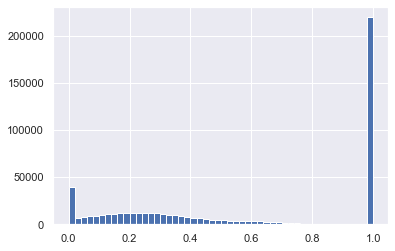

In [427]:
plt.hist(s1_img.reshape(-1), bins=50)
plt.show()

# Read single label

In [ ]:
train_path[train_path.chip_id == 'wvy02']

In [264]:
# label_path = train_path.label_path[1]
label_path = train_path[train_path.chip_id == 'wvy02'].label_path.iloc[0]
label_path

'data/train_labels/wvy02.tif'

In [265]:
with rasterio.open(label_path) as lp:
    lp_img = lp.read(1)

In [266]:
lp_img

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [267]:
values, counts = np.unique(lp_img, return_counts=True)
values, counts

(array([1], dtype=uint8), array([262144]))

In [268]:
label_to_show = np.ma.masked_where((lp_img == 0) | (lp_img == 255), lp_img)

In [269]:
label_to_show

masked_array(
  data=[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],
  mask=False,
  fill_value=999999,
  dtype=uint8)

In [75]:
for i, v in enumerate(values):
    column = value_to_column[v]
    count = counts[i]
    print(column, count)
    train_path.loc[i, column] = count

ground 262144


In [76]:
512*512

262144

In [271]:
from plot_utils import show_image

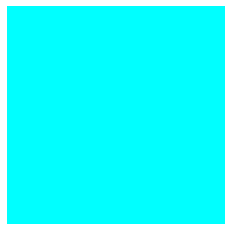

In [272]:
show_image(label_to_show, cmap='cool')

# Read images

In [37]:
os.listdir(PATH_TO_DATA)

['flood-training-metadata.csv', 'train_features', 'train_labels']

In [46]:
feature_path = os.path.join(PATH_TO_DATA, 'train_features')
label_path = os.path.join(PATH_TO_DATA, 'train_labels')

In [230]:
image_id = train_metadata['image_id'][0] # 0, 13
image_id = f'{image_id}.tif'
image_path = os.path.join(feature_path, image_id)

In [231]:
with rasterio.open(image_path) as img:
    metadata = img.meta
    bounds = img.bounds
    data = img.read(1)

In [232]:
metadata

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 0.0,
 'width': 512,
 'height': 512,
 'count': 1,
 'crs': CRS.from_epsg(32720),
 'transform': Affine(10.0, 0.0, 314030.0,
        0.0, -10.0, 8585890.0)}

In [233]:
bounds

BoundingBox(left=314030.0, bottom=8580770.0, right=319150.0, top=8585890.0)

In [234]:
data.shape

(512, 512)

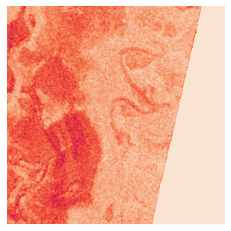

In [229]:
show_image(data)

In [59]:
with rasterio.open(image_path) as img:
    gdal_mask = img.dataset_mask()

In [60]:
gdal_mask

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

In [61]:
with rasterio.open(image_path) as img:
    numpy_mask = img.read(1, masked=True)

In [62]:
numpy_mask

masked_array(
  data=[[-16.20801544189453, -17.71950912475586, -16.281352996826172,
         ..., --, --, --],
        [-15.328896522521973, -18.231857299804688, -16.451892852783203,
         ..., --, --, --],
        [-15.353134155273438, -16.888309478759766, -15.585904121398926,
         ..., --, --, --],
        ...,
        [-15.74166202545166, -15.230668067932129, -13.455254554748535,
         ..., --, --, --],
        [-15.498257637023926, -14.100983619689941, -13.110269546508789,
         ..., --, --, --],
        [-16.05560302734375, -14.112099647521973, -14.76084041595459,
         ..., --, --, --]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=0.0,
  dtype=f

# Dataset

In [463]:
train_metadata.head()

image_id chip_id flood_id polarization location scene_start  \
0  awc00_vh   awc00      awc           vh  Bolivia  2018-02-15   
1  awc00_vv   awc00      awc           vv  Bolivia  2018-02-15   
2  awc01_vh   awc01      awc           vh  Bolivia  2018-02-15   
3  awc01_vv   awc01      awc           vv  Bolivia  2018-02-15   
4  awc02_vh   awc02      awc           vh  Bolivia  2018-02-15   

                       feature_path                   label_path  
0  data/train_features/awc00_vh.tif  data/train_labels/awc00.tif  
1  data/train_features/awc00_vv.tif  data/train_labels/awc00.tif  
2  data/train_features/awc01_vh.tif  data/train_labels/awc01.tif  
3  data/train_features/awc01_vv.tif  data/train_labels/awc01.tif  
4  data/train_features/awc02_vh.tif  data/train_labels/awc02.tif

In [110]:
train = train_metadata

In [132]:
train_x = get_paths_by_chip(train)
train_x.head()

chip_id                           vv_path                           vh_path
0   awc00  data/train_features/awc00_vv.tif  data/train_features/awc00_vh.tif
1   awc01  data/train_features/awc01_vv.tif  data/train_features/awc01_vh.tif
2   awc02  data/train_features/awc02_vv.tif  data/train_features/awc02_vh.tif
3   awc03  data/train_features/awc03_vv.tif  data/train_features/awc03_vh.tif
4   awc04  data/train_features/awc04_vv.tif  data/train_features/awc04_vh.tif

In [133]:
train_y = train[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)
train_y.head()

chip_id                   label_path
0   awc00  data/train_labels/awc00.tif
1   awc01  data/train_labels/awc01.tif
2   awc02  data/train_labels/awc02.tif
3   awc03  data/train_labels/awc03.tif
4   awc04  data/train_labels/awc04.tif

In [264]:
from dataset import FloodDataset

In [265]:
train_dataset = FloodDataset(train_x, train_y, transforms=None)

In [138]:
len(train_dataset)

542

In [178]:
sample_data = train_dataset[0]

In [180]:
chip = sample_data['chip']
chip.shape

(2, 512, 512)

In [181]:
label = sample_data['label']
label.shape

(512, 512)

In [182]:
np.unique(label)

array([  0, 255], dtype=uint8)

In [190]:
chip[0].shape

(512, 512)

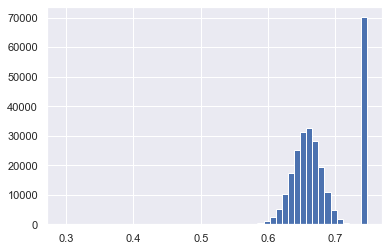

In [195]:
plt.hist(chip[0].reshape(-1), bins=50)
plt.show()

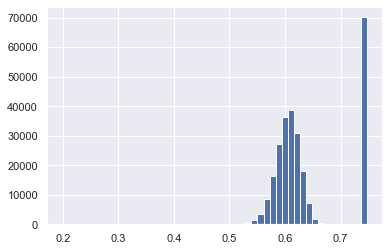

In [196]:
plt.hist(chip[1].reshape(-1), bins=50)
plt.show()

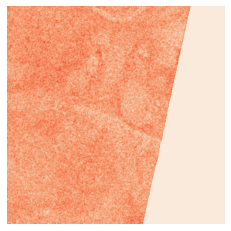

In [197]:
show_image(chip[0])

# Single model path¶

In [199]:
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
#     num_workers=0,
#     pin_memory=True
)

In [200]:
train_loader_iter = iter(train_loader)

In [204]:
data_dict = next(train_loader_iter)

id_batch = data_dict['chip_id']
x_batch = data_dict['chip']
y_batch = data_dict['label']

In [205]:
id_batch

['wvy08', 'kuo21', 'wvy29', 'jja21']

In [207]:
x_batch.shape

torch.Size([4, 2, 512, 512])

In [248]:
y_batch.shape, y_batch.dtype

(torch.Size([4, 512, 512]), torch.uint8)

In [238]:
import segmentation_models_pytorch as smp

In [239]:
encoder_name = 'resnet18'
encoder_weights = 'imagenet'

unet_model = smp.Unet(
    encoder_name=encoder_name,
    encoder_weights=encoder_weights,
    in_channels=2,
    classes=2,
)

In [241]:
# unet_model

In [242]:
output = unet_model(x_batch)

In [243]:
output.shape

torch.Size([4, 2, 512, 512])

In [261]:
loss = nn.CrossEntropyLoss(ignore_index=255)

In [249]:
y_batch = y_batch.type(torch.long)

In [250]:
loss_value = loss(output, y_batch)
loss_value

tensor(0.8681, grad_fn=<NllLoss2DBackward>)

In [292]:
preds = torch.softmax(output, dim=1)[:, 1]
preds.shape

torch.Size([4, 512, 512])

In [296]:
preds = (preds > 0.5) * 1
# preds

In [300]:
correct_pixels = (preds == y_batch).sum()
all_pixels = torch.tensor(preds.size()).prod()

In [303]:
correct_pixels, all_pixels, correct_pixels/all_pixels

(tensor(499494), tensor(1048576), tensor(0.4764))